# Method comparsion

## Library imports

In [1]:
import os
import sys
from itertools import chain, product
from typing import Dict, Optional

import numpy as np
import pandas as pd
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

sys.path.extend(["../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

## General settings

In [2]:
SAVE_FIGURES = False

if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "labeling_kernel", exist_ok=True)

## Constants

In [3]:
TERMINAL_STATES = ["Enterocytes", "Enteroendocrine progenitors", "Goblet cells", "Paneth cells"]

## Function definition

In [4]:
def get_optimal_auc(n_vars):
    """Compute AUC if given all genes are ranked first."""
    return n_vars * (n_vars + 1) / 2 + (2000 - n_vars) * n_vars

In [5]:
def plot_method_comparison(gene_ranks, method_pairs, terminal_state, criteria):
    """Plot performance of each method w.r.t. gene ranking."""
    n_cols = len(method_pairs)
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6 * n_cols, 6), ncols=n_cols)

        for ax_id, methods in enumerate(method_pairs):
            method_a, method_b = methods
            _df = gene_ranks[terminal_state]

            ranks_a = _df.loc[_df["Algorithm"] == method_a].set_index("NAME")
            ranks_b = _df.loc[_df["Algorithm"] == method_b].set_index("NAME")

            ranks_a, ranks_b = ranks_a.align(ranks_b)

            df = pd.DataFrame(
                {
                    f"{method_a}": ranks_a[criteria],
                    f"{method_b}": ranks_b[criteria],
                }
            )
            a_better_b = (ranks_a[criteria] < ranks_b[criteria]).sum() / ranks_a[criteria].size * 100

            sns.scatterplot(data=df, x=method_a, y=method_b, ax=ax[ax_id])

            lims = [
                np.min([ax[ax_id].get_xlim(), ax[ax_id].get_ylim()]),  # min of both axes
                np.max([ax[ax_id].get_xlim(), ax[ax_id].get_ylim()]),  # max of both axes
            ]

            # now plot both limits against eachother
            ax[ax_id].plot(lims, lims, "k-", alpha=0.75, zorder=0)
            ax[ax_id].set_aspect("equal")
            ax[ax_id].set_xlim(lims)
            ax[ax_id].set_ylim(lims)

            ax[ax_id].set_title(f'"{method_a}" < "{method_b}": {a_better_b:.2f}%')

        plt.tight_layout()
        plt.show()

In [6]:
def get_gene_ranks():
    """Loads gene ranking of each method."""
    gene_ranks = {}
    for terminal_state in TERMINAL_STATES:
        # If Dynamo is included: [[f"Corr. rank - {terminal_state}", "Algorithm", "Run"]].fillna(0)
        gene_ranks[terminal_state] = (
            pd.concat(
                [
                    pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / f"gene_ranks_{terminal_state}-cr2.csv"),
                    pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / f"gene_ranks_gex_{terminal_state}-cr2.csv"),
                    pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / f"gene_ranks_{terminal_state}-em_model.csv"),
                ]
            )
            .rename(columns={"Unnamed: 0": "Gene"})
            .drop_duplicates(subset=["Gene", "Algorithm"])[["Gene", f"Corr. rank - {terminal_state}", "Algorithm"]]
        )

        # gene_ranks[terminal_state].replace({"EM Model": "scVelo"}, inplace=True)
        gene_ranks[terminal_state].replace(
            {"CR2": "CellRank 2 (transcription rate)", "CR2 - GEX": "CellRank 2 (GEX)", "EM Model": "CellRank 1"},
            inplace=True,
        )

        # Random rank assignment
        np.random.seed(0)
        var_names = (
            gene_ranks[terminal_state]
            .loc[gene_ranks[terminal_state]["Algorithm"] == "CellRank 2 (transcription rate)", "Gene"]
            .unique()
        )
        random_ranking = pd.DataFrame(
            {
                "Gene": var_names,
                f"Corr. rank - {terminal_state}": np.random.choice(np.arange(2000), size=len(var_names), replace=False),
                "Algorithm": "Random assignment",
            }
        )

        # Optimal gene ranking
        optimal_ranking = pd.DataFrame(
            {
                "Gene": var_names,
                f"Corr. rank - {terminal_state}": np.arange(len(var_names)),
                "Algorithm": "Optimal assignment",
            }
        )
        gene_ranks[terminal_state] = pd.concat([gene_ranks[terminal_state], random_ranking, optimal_ranking])
    return gene_ranks

In [7]:
def get_rank_threshold(gene_ranks, n_methods):
    """Computes number of genes ranked below a given threshold for each method."""
    rank_threshold = np.arange(0, 2000)
    dfs = {}

    for terminal_state in TERMINAL_STATES:
        col_name = f"Corr. rank - {terminal_state}"

        if "Run" in gene_ranks[terminal_state].columns:
            dfs[terminal_state] = pd.DataFrame(
                gene_ranks[terminal_state]
                .groupby(["Algorithm", "Run"])
                .apply(lambda x: (x[col_name].values <= rank_threshold.reshape(-1, 1)).sum(axis=1))  # noqa: B023
                .to_dict()
            )
            dfs[terminal_state] = pd.melt(dfs[terminal_state]).rename(
                {"variable_0": "Algorithm", "variable_1": "Run", "value": "Rank CDF"}, axis=1
            )
            dfs[terminal_state]["Rank threshold"] = np.concatenate([rank_threshold] * n_methods[terminal_state])
        else:
            dfs[terminal_state] = pd.DataFrame(
                gene_ranks[terminal_state]
                .groupby(["Algorithm"])
                .apply(lambda x: (x[col_name].values <= rank_threshold.reshape(-1, 1)).sum(axis=1))  # noqa: B023
                .to_dict()
            )
            dfs[terminal_state] = pd.melt(dfs[terminal_state]).rename(
                {"variable": "Algorithm", "value": "Rank CDF"}, axis=1
            )
            dfs[terminal_state]["Rank threshold"] = np.concatenate([rank_threshold] * n_methods[terminal_state])
    return dfs

In [8]:
def plot_gene_ranking(rank_threshold, methods, fname: str = "", palette: Optional[Dict[str, str]] = None):
    """Plots number of ranked genes below a specified threshold."""
    _n_methods = list(map(len, methods.values()))
    _argmax_n_methods = np.argmax(_n_methods)
    _methods = list(methods.values())[_argmax_n_methods]
    _n_methods = _n_methods[_argmax_n_methods]

    if palette is None:
        palette = dict(zip(_methods, sns.color_palette("colorblind").as_hex()[:_n_methods]))
        palette["Optimal assignment"] = "#000000"

    with mplscience.style_context():
        sns.set_style(style="whitegrid")

        fig, ax = plt.subplots(figsize=(6 * len(TERMINAL_STATES), 4), ncols=len(TERMINAL_STATES))

        for ax_id, terminal_state in enumerate(TERMINAL_STATES):
            _df = rank_threshold[terminal_state]
            _df["line_style"] = "-"
            _df.loc[_df["Algorithm"] == "Optimal assignment", "line_style"] = "--"
            sns.lineplot(
                data=_df,
                x="Rank threshold",
                y="Rank CDF",
                hue="Algorithm",
                style=_df["line_style"].tolist(),
                palette=palette,
                ax=ax[ax_id],
            )
            ax[ax_id].set_title(terminal_state)
            if ax_id == 0:
                handles, labels = ax[ax_id].get_legend_handles_labels()
                handles[3].set_linestyle("--")
            ax[ax_id].get_legend().remove()

        handles = [handles[0], handles[1], handles[2], handles[5], handles[4], handles[3]]
        labels = [labels[0], labels[1], labels[2], labels[5], labels[4], labels[3]]
        fig.legend(handles=handles[:6], labels=labels[:6], loc="lower center", ncol=6, bbox_to_anchor=(0.5, -0.15))
        plt.tight_layout()
        plt.show()

        if SAVE_FIGURES:
            for terminal_state in TERMINAL_STATES:
                sns.set_style(style="whitegrid")
                fig, ax = plt.subplots(figsize=(5, 4))
                _df = rank_threshold[terminal_state]
                _df["line_style"] = "-"
                _df.loc[_df["Algorithm"] == "Optimal assignment", "line_style"] = "--"
                sns.lineplot(
                    data=_df,
                    x="Rank threshold",
                    y="Rank CDF",
                    hue="Algorithm",
                    style=_df["line_style"].tolist(),
                    palette=palette,
                    ax=ax,
                )
                ax.set(xlabel=None, xticklabels=[], yticklabels=[], ylabel=None, title="")
                ax.get_legend().remove()

                fig.savefig(
                    FIG_DIR / "labeling_kernel" / f"{fname}_{terminal_state}.pdf",
                    format="pdf",
                    transparent=True,
                    bbox_inches="tight",
                )

                plt.show()

In [9]:
def get_aucs(gene_ranking_dfs, optimal_aucs, methods):
    """Computes area under the ranking threshold curve."""
    all_methods = list(set(chain(*methods.values())))

    # Absolute AUC
    auc_df = pd.DataFrame(index=all_methods, columns=TERMINAL_STATES, dtype=float)

    # Given AUC w.r.t. optimal AUC
    auc_rel_df = pd.DataFrame(index=all_methods, columns=TERMINAL_STATES, dtype=float)

    rank_threshold = np.arange(0, 2000)
    aucs_ = {terminal_state: {} for terminal_state in TERMINAL_STATES}
    for method, terminal_state in product(all_methods, TERMINAL_STATES):
        _df = gene_ranking_dfs[terminal_state]
        if (method == "Dynamo") and _df["Algorithm"].isin([method]).any():
            aucs_[terminal_state][method] = [
                auc(x=rank_threshold, y=_df.loc[(_df["Algorithm"] == method) & (_df["Run"] == run), "Rank CDF"].values)
                for run in _df["Run"].unique()
            ]
            auc_df.loc[method, terminal_state] = np.mean(aucs_[terminal_state][method])
            auc_rel_df.loc[method, terminal_state] = (
                auc_df.loc[method, terminal_state] / optimal_aucs[terminal_state].loc[method]
            )
        elif method == "Dynamo":
            pass
        else:
            aucs_[terminal_state][method] = auc(
                x=rank_threshold, y=_df.loc[_df["Algorithm"] == method, "Rank CDF"].values
            )
            auc_df.loc[method, terminal_state] = aucs_[terminal_state][method]
            auc_rel_df.loc[method, terminal_state] = (
                auc_df.loc[method, terminal_state] / optimal_aucs[terminal_state].loc[method]
            )
    return auc_df, auc_rel_df

## Data loading

In [10]:
gene_ranks = get_gene_ranks()

In [11]:
for terminal_state in TERMINAL_STATES:
    if (
        DATA_DIR
        / "sceu_organoid"
        / "results"
        / f"gene_ranks_{terminal_state}-chase_and_pulse-dynamo_terminal_states-dynamo.csv"
    ).is_file():
        gene_ranks[terminal_state] = pd.concat(
            [
                gene_ranks[terminal_state],
                pd.read_csv(
                    DATA_DIR
                    / "sceu_organoid"
                    / "results"
                    / f"gene_ranks_{terminal_state}-chase_and_pulse-dynamo_terminal_states-dynamo.csv"
                )
                .rename(columns={"Unnamed: 0": "Gene"})
                .drop_duplicates(subset=["Gene", "Algorithm", "Run"]),
            ]
        ).fillna(0)
        gene_ranks[terminal_state]["Run"] = gene_ranks[terminal_state]["Run"].astype(int)

In [12]:
methods = {}
n_methods = {}

for terminal_state in TERMINAL_STATES:
    methods[terminal_state] = gene_ranks[terminal_state]["Algorithm"].unique().tolist()
    if "Run" in gene_ranks[terminal_state].columns:
        n_methods[terminal_state] = gene_ranks[terminal_state][["Algorithm", "Run"]].drop_duplicates().shape[0]
    else:
        n_methods[terminal_state] = len(methods[terminal_state])

## Comparison

In [13]:
dfs = get_rank_threshold(gene_ranks=gene_ranks, n_methods=n_methods)

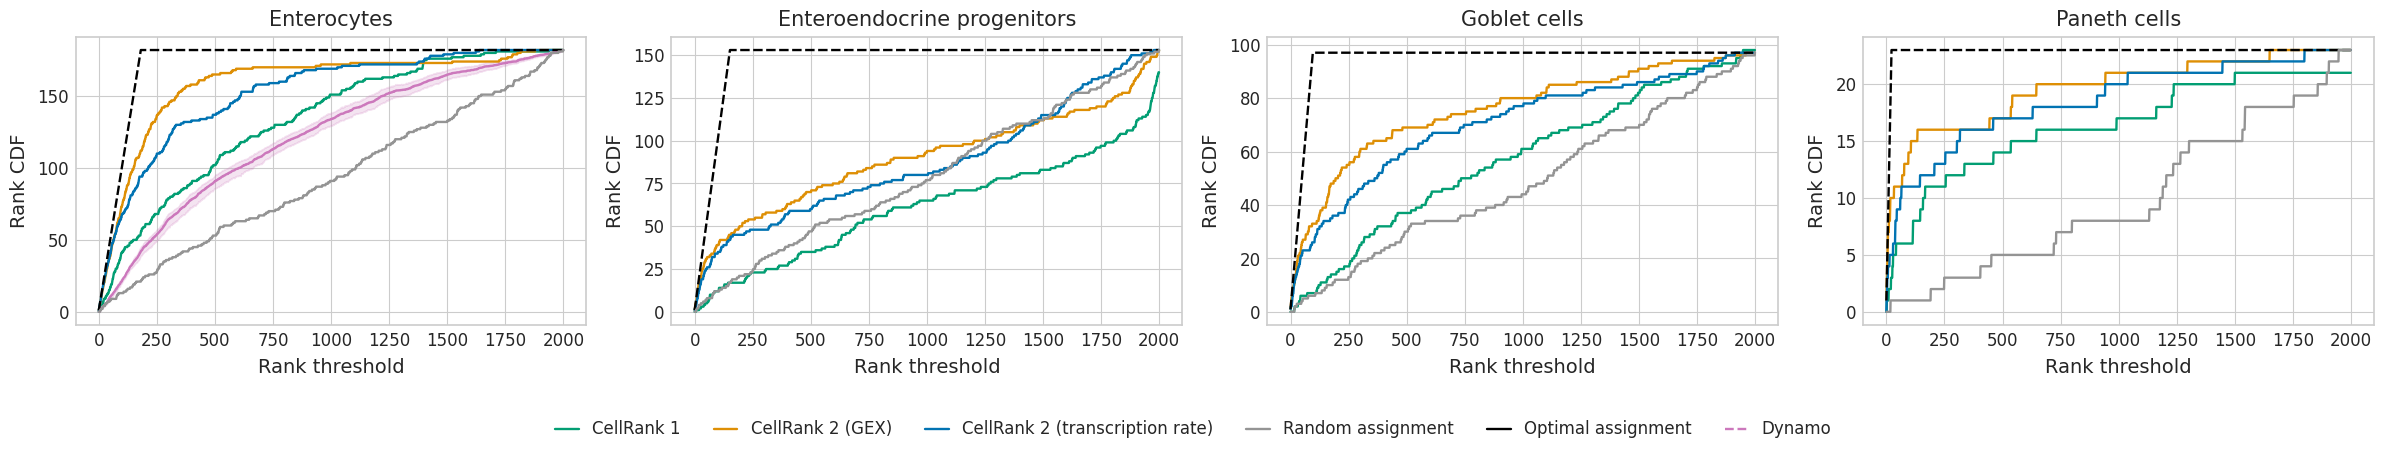

In [14]:
palette = {
    "CellRank 2 (transcription rate)": "#0173b2",
    "CellRank 2 (GEX)": "#de8f05",
    "CellRank 1": "#029e73",
    "Dynamo": "#cc78bc",
    "Random assignment": "#949494",
    "Optimal assignment": "#000000",
}

plot_gene_ranking(rank_threshold=dfs, methods=methods, fname="rank_analysis", palette=palette)

In [15]:
optimal_aucs = {}

for terminal_state in TERMINAL_STATES:
    if "Run" in gene_ranks[terminal_state].columns:
        optimal_aucs[terminal_state] = gene_ranks[terminal_state].groupby(["Algorithm"]).size() / gene_ranks[
            terminal_state
        ].groupby(["Algorithm"]).apply(lambda x: len(x["Run"].unique()))
    else:
        optimal_aucs[terminal_state] = gene_ranks[terminal_state].groupby("Algorithm").size()
    optimal_aucs[terminal_state] = get_optimal_auc(optimal_aucs[terminal_state])

In [16]:
_, auc_rel_df = get_aucs(gene_ranking_dfs=dfs, optimal_aucs=optimal_aucs, methods=methods)
auc_rel_df

,Enterocytes,Enteroendocrine progenitors,Goblet cells,Paneth cells
Optimal assignment,0.999737,0.999738,0.999741,0.999738
CellRank 2 (GEX),0.915893,0.610649,0.801061,0.860166
Random assignment,0.535365,0.538473,0.513745,0.435755
CellRank 2 (transcription rate),0.878167,0.590511,0.744919,0.813857
CellRank 1,0.769516,0.453206,0.599141,0.785032
Dynamo,0.700409,NaN,NaN,NaN


## Dynamo with CR terminal states

In [17]:
gene_ranks = get_gene_ranks()

In [18]:
for terminal_state in TERMINAL_STATES:
    if (
        DATA_DIR
        / "sceu_organoid"
        / "results"
        / f"gene_ranks_{terminal_state}-chase_and_pulse-cr_terminal_states-dynamo.csv"
    ).is_file():
        gene_ranks[terminal_state] = pd.concat(
            [
                gene_ranks[terminal_state],
                pd.read_csv(
                    DATA_DIR
                    / "sceu_organoid"
                    / "results"
                    / f"gene_ranks_{terminal_state}-chase_and_pulse-cr_terminal_states-dynamo.csv"
                )
                .rename(columns={"Unnamed: 0": "Gene"})
                .drop_duplicates(subset=["Gene", "Algorithm", "Run"]),
            ]
        ).fillna(0)
        gene_ranks[terminal_state]["Run"] = gene_ranks[terminal_state]["Run"].astype(int)

In [19]:
methods = {}
n_methods = {}

for terminal_state in TERMINAL_STATES:
    methods[terminal_state] = gene_ranks[terminal_state]["Algorithm"].unique().tolist()
    if "Run" in gene_ranks[terminal_state].columns:
        n_methods[terminal_state] = gene_ranks[terminal_state][["Algorithm", "Run"]].drop_duplicates().shape[0]
    else:
        n_methods[terminal_state] = len(methods[terminal_state])

In [20]:
dfs = get_rank_threshold(gene_ranks=gene_ranks, n_methods=n_methods)

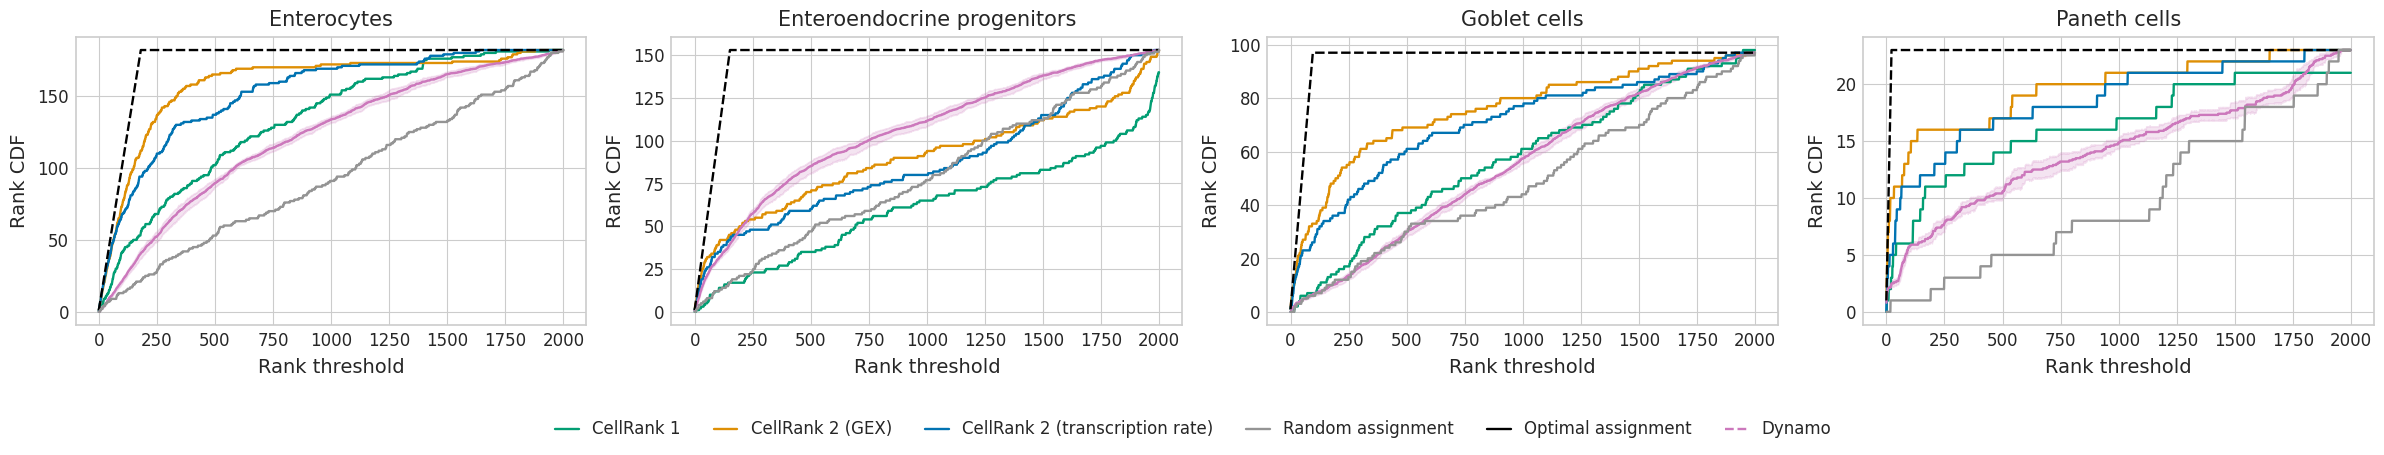

In [21]:
palette = {
    "CellRank 2 (transcription rate)": "#0173b2",
    "CellRank 2 (GEX)": "#de8f05",
    "CellRank 1": "#029e73",
    "Dynamo": "#cc78bc",
    "Random assignment": "#949494",
    "Optimal assignment": "#000000",
}

plot_gene_ranking(rank_threshold=dfs, methods=methods, fname="rank_analysis_w_cr_terminal_states", palette=palette)

In [22]:
optimal_aucs = {}

for terminal_state in TERMINAL_STATES:
    if "Run" in gene_ranks[terminal_state].columns:
        optimal_aucs[terminal_state] = gene_ranks[terminal_state].groupby(["Algorithm"]).size() / gene_ranks[
            terminal_state
        ].groupby(["Algorithm"]).apply(lambda x: len(x["Run"].unique()))
    else:
        optimal_aucs[terminal_state] = gene_ranks[terminal_state].groupby("Algorithm").size()
    optimal_aucs[terminal_state] = get_optimal_auc(optimal_aucs[terminal_state])

In [23]:
_, auc_rel_df = get_aucs(gene_ranking_dfs=dfs, optimal_aucs=optimal_aucs, methods=methods)
auc_rel_df

,Enterocytes,Enteroendocrine progenitors,Goblet cells,Paneth cells
Optimal assignment,0.999737,0.999738,0.999741,0.999738
CellRank 2 (GEX),0.915893,0.610649,0.801061,0.860166
Random assignment,0.535365,0.538473,0.513745,0.435755
CellRank 2 (transcription rate),0.878167,0.590511,0.744919,0.813857
CellRank 1,0.769516,0.453206,0.599141,0.785032
Dynamo,0.700308,0.720271,0.578212,0.624054
